# <span style="color:#0F19C9">Contenido</span>

- [Importar librerías y archivos](#importar-librerías-y-archivos)
- [Preprocesar características](#preprocesar-características)
- [Entrenar modelos](#entrenar-modelos)
    - [Regresión Lineal](#regresión-lineal)

# <span style="color:#0F19C9">Importar librerías y archivos</span>

Vamos a importar las librerías para el manejo de dataframes y las correspondientes para construir modelos de Machine Learning. Decidimos no importar el archivo de Outliers para mejorar el entrenamiento del modelo.

In [581]:
# Importar librerías de manejo de dataframes y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Importar librería de preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importar librerías de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Importar librería para evaluación de modelos
from sklearn.metrics import mean_squared_error

In [582]:
# Importar mi paleta de colores
juan_colors = ['#101B4B', '#545E85', '#A3A8B2',
               '#E7E7E7', '#0F19C9', '#F6D673']

# Crear la paleta de colores personalizada
colors = [juan_colors[5], juan_colors[0]]
juan_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Configurar la fuente de los gráficos
plt.rc('font', family='Georgia', size=12)

In [583]:
# Importar los archivos con las publicaciones
mexico = pd.read_csv('../Data/Mexico.csv')
norteno = pd.read_csv('../Data/Norteno.csv')
popular = pd.read_csv('../Data/Popular.csv')

In [584]:
# Concatenar los archivos
df = pd.concat([mexico,
                norteno,
                popular])

# Borrar dataframes temporales
del ([mexico, norteno, popular])

In [585]:
# Formatear la columna Fecha y Hora
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], utc=True)
df['Fecha y Hora'] = df['Fecha y Hora'].dt.tz_convert('America/Bogota')

# Mostrar 3 registros aleatorios
df.sample(3)

,Artista,Seguidores,Tipo,Fecha y Hora,KPI,Likes,Comentarios,Caption,Palabras en Caption,Número de hashtags,Hashtags
67,Bobby Pulido,162000,Reel,2024-08-16 12:14:41-05:00,1.000000e-03,162,11,🔥 Ya Esta Disponible 😱 #MedleyBobbyPulido con ...,29,2,"['#MedleyBobbyPulido', '#ZumbaleCanelo']"
54,Yeison Jiménez,5000000,Foto,2024-09-19 10:11:26-05:00,6.000000e-07,3,40,🔥EL MEJOR 🔥REMIX👌🏻💣🇲🇽🇨🇴 @yeison_jimenez,4,0,[]
11,Los Tigres del Norte,2000000,Foto,2024-09-15 01:54:35-05:00,1.057250e-02,21145,148,¡Gracias Bogotá! 🇨🇴Tres noches inolvidables en...,44,3,"['#AquíMandoYo', '#LTDN', '#ActitudTigres']"


In [586]:
# Mostrar la información general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 0 to 68
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                         
---  ------               --------------  -----                         
 0   Artista              214 non-null    object                        
 1   Seguidores           214 non-null    int64                         
 2   Tipo                 214 non-null    object                        
 3   Fecha y Hora         214 non-null    datetime64[ns, America/Bogota]
 4   KPI                  214 non-null    float64                       
 5   Likes                214 non-null    int64                         
 6   Comentarios          214 non-null    int64                         
 7   Caption              213 non-null    object                        
 8   Palabras en Caption  214 non-null    int64                         
 9   Número de hashtags   214 non-null    int64                         
 10  Hashtags            

# <span style="color:#0F19C9">Preprocesar características</span>

Queremos determinar el KPI de las diferentes publicaciones, por lo que construiremos una regresión lineal basándonos en las otras características que podamos crear. La columna objetivo es `KPI`. Sin embargo, la columna `Artista`, `Seguidores`, `Likes`, `Comentarios`, `Caption` y `Hashtags` no las usaremos porque algunas de ellas no las controlamos en una estrategia de publicación y otras porque, como lo vimos en el análisis, como la columna de Comentarios, no nos aporta mayor información al modelo.

In [587]:
# Eliminar columnas innecesarias para el modelo
df = df[['Tipo', 'Fecha y Hora', 'Palabras en Caption', 'Número de hashtags', 'KPI']]
df.sample(3)

,Tipo,Fecha y Hora,Palabras en Caption,Número de hashtags,KPI
65,Reel,2024-08-24 21:27:10-05:00,46,5,0.003312
12,Reel,2024-08-21 18:12:57-05:00,26,2,0.017619
62,Foto,2024-09-10 18:43:35-05:00,8,0,0.003425


In [588]:
# Crear One-Hot Encoder con la columna Tipo
df = pd.concat([df,
                pd.get_dummies(df['Tipo'], prefix='Tipo',
                               drop_first=True, dtype=int)], axis=1)
df.drop('Tipo', axis=1, inplace=True)

In [589]:
# Extraer información de la columna Fecha y Hora
df['Día de la publicación'] = df['Fecha y Hora'].dt.day
df['Día de la semana'] = df['Fecha y Hora'].dt.dayofweek
df['Hora de publicación'] = df['Fecha y Hora'].dt.hour
df.drop('Fecha y Hora', axis=1, inplace=True)

In [590]:
# Organizar las columnas
df = df[['Palabras en Caption', 'Número de hashtags', 'Tipo_Foto',
         'Tipo_Reel', 'Tipo_Video', 'Día de la publicación', 'Día de la semana',
         'Hora de publicación', 'KPI']]

# Separar los datos en entrenamiento y validación
train_df, test_df = train_test_split(df, test_size=0.2)

# Separar características
target = 'KPI'
categories = ['Tipo_Foto', 'Tipo_Reel', 'Tipo_Video']
features = [column for column in df.columns if (
    column not in target) and (column not in categories)]

In [591]:
# Estandarizar las columnas
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

# Mostrar 3 registros aleatorios de entrenamiento
train_df.sample(3)

,Palabras en Caption,Número de hashtags,Tipo_Foto,Tipo_Reel,Tipo_Video,Día de la publicación,Día de la semana,Hora de publicación,KPI
35,1.547881,-0.655877,0,0,0,-1.861437,-1.569560,-0.526447,0.000535
5,-0.547272,-0.655877,1,0,0,0.159980,-1.015025,0.837530,0.002710
1,-1.046118,-0.439779,0,0,0,0.429502,0.094044,-1.111009,0.001649


Una vez establecimos las columnas importantes para nuestro contenido, extraemos la mayor cantidad de información de ellas y finalmente las estandarizamos para que ninguna de ellas represente un sesgo para nuestro modelo.

# <span style="color:#0F19C9">Entrenar modelos</span>

In [592]:
# Crear diccionario de métricas
models = {}

## <span style="color:#0F19C9">Regresión Lineal</span>

In [593]:
# Entrenar modelo de Regresión Lineal
model_1 = LinearRegression()
model_1.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_1.predict(test_df[features + categories])
models['Regresión Lineal'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión Lineal es:',
      models['Regresión Lineal'])

El RMSE en el modelo de Regresión Lineal es: 0.004225451542867046


## <span style="color:#0F19C9">Ridge</span>

In [594]:
# Entrenar modelo de Ridge
model_2 = Ridge(alpha=1.0)
model_2.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_2.predict(test_df[features + categories])
models['Ridge'] = mean_squared_error(predictions, test_df[target])**0.5
print('El RMSE en el modelo de Ridge es:', models['Ridge'])

El RMSE en el modelo de Ridge es: 0.004225370277329936


## <span style="color:#0F19C9">Lasso</span>

In [595]:
# Entrenar modelo de Lasso
model_3 = Ridge(alpha=0.1)
model_3.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_3.predict(test_df[features + categories])
models['Lasso'] = mean_squared_error(predictions, test_df[target])**0.5
print('El RMSE en el modelo de Lasso es:', models['Lasso'])

El RMSE en el modelo de Lasso es: 0.004225435616453748


## <span style="color:#0F19C9">Regresión de Soporte de Vectores</span>

In [596]:
# Entrenar modelo de Regresión de Soporte de Vectores
model_4 = SVR(kernel='rbf')
model_4.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_4.predict(test_df[features + categories])
models['Regresión de Soporte de Vectores'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión de Soporte de Vectores es:',
      models['Regresión de Soporte de Vectores'])

El RMSE en el modelo de Regresión de Soporte de Vectores es: 0.007107101247482309


## <span style="color:#0F19C9">Regresión de Bosque Aleatorio</span>

In [597]:
# Entrenar modelo de Regresión de Bosque Aleatorio
model_5 = RandomForestRegressor()
model_5.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_5.predict(test_df[features + categories])
models['Regresión de Bosque Aleatorio'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión de Bosque Aleatorio es:',
      models['Regresión de Bosque Aleatorio'])

El RMSE en el modelo de Regresión de Bosque Aleatorio es: 0.00462379506341518


## <span style="color:#0F19C9">Regresión de Gradiente</span>

In [598]:
# Entrenar modelo de Regresión de Gradiente
model_6 = GradientBoostingRegressor()
model_6.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_6.predict(test_df[features + categories])
models['Regresión de Gradiente'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión de Gradiente es:',
      models['Regresión de Gradiente'])

El RMSE en el modelo de Regresión de Gradiente es: 0.004594978433257384


# <span style="color:#0F19C9">Evaluar modelos</span>

C:\Users\juanp\AppData\Local\Temp\ipykernel_30140\3811565912.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(models.keys()),


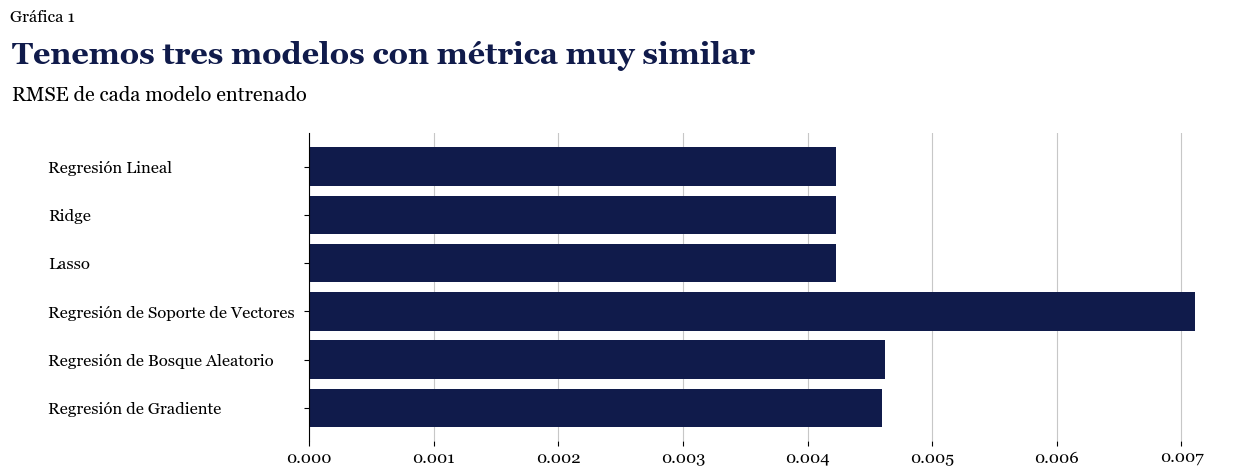

El mejor modelo fue el Ridge que tuvo un RMSE de 0.004225370277329936


In [599]:
# Hacer gráfica de métricas de modelos
fig, ax = plt.subplots(figsize=[12, 4])
plt.text(x=-0.0024, y=-3,
         s='Gráfica 1')
plt.title('Tenemos tres modelos con métrica muy similar',
          weight='bold', size=22,
          x=0.08, y=1.2, color=juan_colors[0])
plt.suptitle('RMSE de cada modelo entrenado',
             x=0, y=1)
plt.barh(y=list(models.keys()),
         width=list(models.values()),
         color=juan_colors[0],
         zorder=2)
ax.set_yticklabels(list(models.keys()),
                   ha='left',
                   x=-.27)
plt.grid(axis='x', alpha=0.7,
         zorder=1)
ax.spines[['top', 'bottom', 'right']].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

# Identificar el mejor modelo
best_model = min(models, key=models.get)
print(
    f'El mejor modelo fue el {best_model} que tuvo un RMSE de {models[best_model]}')

In [600]:
# Encontrar coeficientes del modelo
coeficientes = pd.DataFrame({
    'Característica': model_2.feature_names_in_,
    'Coeficiente': model_2.coef_
})

# Ordenar por valor absoluto
coeficientes['Absoluto'] = np.abs(coeficientes['Coeficiente'])
coeficientes.sort_values('Absoluto', ascending=False, inplace=True)
coeficientes.drop(columns='Absoluto', inplace=True)
coeficientes

,Característica,Coeficiente
4,Hora de publicación,0.000373
1,Número de hashtags,0.000347
5,Tipo_Foto,0.000299
2,Día de la publicación,-0.000213
0,Palabras en Caption,0.000173
6,Tipo_Reel,0.000159
3,Día de la semana,0.000048
7,Tipo_Video,0.000000


C:\Users\juanp\AppData\Local\Temp\ipykernel_30140\3350368762.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(coeficientes['Característica'],


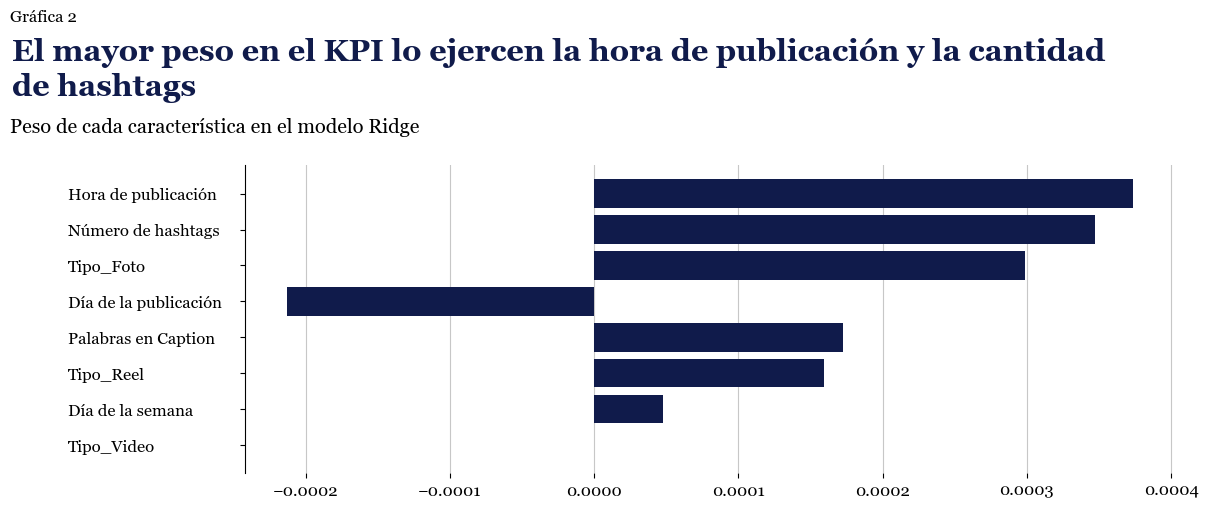

In [640]:
# Hacer gráfica de coeficientes del modelo
fig, ax = plt.subplots(figsize=[12, 4])
plt.text(x=-0.000405, y=-4.8, ha='left',
         s='Gráfica 2')
plt.title('El mayor peso en el KPI lo ejercen la hora de publicación y la cantidad \nde hashtags',
          weight='bold', size=22, ha='left',
          x=-0.25, y=1.2, color=juan_colors[0])
plt.suptitle('Peso de cada característica en el modelo Ridge',
             x=0.1, y=1)
plt.barh(y=coeficientes['Característica'],
         width=coeficientes['Coeficiente'],
         color=juan_colors[0],
         zorder=2)
ax.set_yticklabels(coeficientes['Característica'],
                   ha='left',
                   x=-.18)
plt.grid(axis='x', alpha=0.7,
         zorder=1)
ax.spines[['top', 'bottom', 'right']].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

Podemos entonces concluir, a partir de la evaluación con la métrica de la Raíz del Error Cuadrático Medio, donde el mejor modelo resulta ser el menor valor de error, el mejor modelo es el llamado Ridge con un valor de RMSE de 0.00456.

De este modelo, y más específicamente de sus coeficientes, podemos ver que las dos principales características positivas y con gran fuerza son la hora de publicación y el número de hashtags. Es decir, pareciera ser que, entre más tarde se publique y con más número de hashtags, el KPI tiende a ser mayor.